## Description

This notebook calculates the LAT spacecraft zenith direction given the spacecraft file and uses it to compute the zenith angles of the recorded events. As a sanity check, the results are compared against the values provided by the LAT team.

In [1]:
import logging
import astropy.units as u

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator

from matplotlib import pyplot

In [2]:
def read_ref_time(file_name):
    with fits.open(file_name) as hdus:
        ref_time = Time(
            hdus['Primary'].header['MJDREFI'] + hdus['Primary'].header['MJDREFF'],
            format='mjd',
            scale=hdus['Primary'].header['TIMESYS'].lower()
        )
        
    return ref_time

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s  %(name)s : %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
log = logging.getLogger('main')

## Download data
Data set is a single weekly LAT spacecraft file and the corresponding photon one. The total file size to download is ~40 Mb.

In [4]:
!curl https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/1s_spacecraft/lat_1sec_spacecraft_weekly_w009_p310_v001.fits -o lat_1sec_spacecraft_weekly_w009_p310_v001.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.2M  100 26.2M    0     0   616k      0  0:00:43  0:00:43 --:--:--  740k


In [5]:
!curl https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/lat_photon_weekly_w009_p305_v001.fits -o lat_photon_weekly_w009_p305_v001.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.0M  100 16.0M    0     0   587k      0  0:00:27  0:00:27 --:--:--  730k  0  0:00:28  0:00:27  0:00:01  723k


## Read data files

Spacecraft file is processed with the `LatSpacecraft` class from "latsc.py" that converts spacecraft position to an `EarthLocation` instance.

In [6]:
from latsc import LatSpacecraft

In [7]:
sc = LatSpacecraft(
    'lat_1sec_spacecraft_weekly_w009_p310_v001.fits',
    log=log
)

In [8]:
events = Table.read(
    'lat_photon_weekly_w009_p305_v001.fits',
    format='fits',
    hdu='events'
)

## Compute event zenith angles

In [9]:
evt_coord = SkyCoord(
    events['RA'],
    events['DEC'],
    unit='deg',
    frame='fk5'
)

Convert events observation time to astropy's `Time` accounting for the zero point defined in the FITS file.

In [10]:
ref_time = read_ref_time('lat_photon_weekly_w009_p305_v001.fits')
obstime = Time(
    events['TIME'] + ref_time.gps,
    format='gps',
    scale='utc'
)

Calculate spacecraft zenith direction at that time. `LatSpacecraft` class performs linear interpolation of the zenith RA/Dec at the moments spacefied in the spacecraft file to those of the events. 

Given the 1 sec step of the spacecraft file and roughly 1.5 hr orbit, expected accuracy should be better than `360 / (1.5*3600) ~ 0.07 deg`

In [11]:
sc_zenith = sc.sc_zenith(obstime)

Now compute events zenith / azimuthal angles and offset with respect to the reference values from the LAT files

In [12]:
with erfa_astrom.set(ErfaAstromInterpolator(0.1 * u.s)):
    evt_zenith_angle = evt_coord.separation(sc_zenith)
    evt_pos_angle = evt_coord.position_angle(sc_zenith)

In [13]:
offset = evt_zenith_angle.deg - events['ZENITH_ANGLE']

## Compare results

Comparying the results for the first 10000 events. Difference w.r.t to the reference is scattered within ~0.15 deg and is clearly correlated with events' azimuth angle.

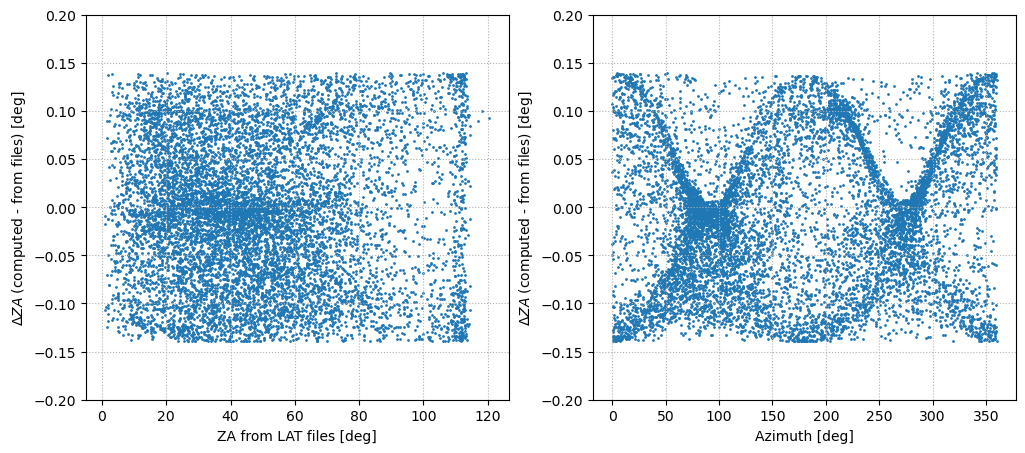

In [14]:
pyplot.figure(figsize=(12, 5))

n = 10000

pyplot.subplot(121)
pyplot.xlabel('ZA from LAT files [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed - from files) [deg]')
pyplot.scatter(
    events['ZENITH_ANGLE'][:n],
    offset[:n],
    marker='o',
    s=1,
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')

pyplot.subplot(122)
pyplot.xlabel('Azimuth [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed - from files) [deg]')
pyplot.scatter(
    evt_pos_angle.deg[:n],
    offset[:n],
    marker='o',
    s=1
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')